# __Etapy modelowania z wykorzystaniem danych__

## I. Akwizycja danych

* Źródła danych (czy dane są __rozproszone__ czy dostępne w jednym miejscu?)
* Pomiary / obserwacje

## II. Oczyszczanie i reorganizacja danych  

* Określenie typów zmiennych i struktur danych
* Obsługa brakujących wartości
* Wykrywanie obserwacje odstających / nietypowych
* Określenie zasad zarządzania danymi, by algorytmy były wykonywane efektywnie (czy dane są __duże__?)

## III. Wizualizacja danych i wstępna ocena cech

* rozkłady
* histogramy
* wykresy pudełkowe
* tabele koincydencji
* wykresy rozrzutu
* mapy ciepła
* ... 

## IV. Modelowanie danych (uczenie maszynowe: predykcja, klasyfikacja, analiza skupień, ...)

#### __IV a.__ ___Sformułowanie problemu / celu___ 

* co jest dane, co jest szukane

* założenia

* wskaźniki jakości

* ograniczenia

#### __IV b.__ ___Inżynieria cech___

* skalowanie (standaryzacja, normalizacja, transformacja)
* dyskretyzacja, binaryzacja
* _ekstrakcja_ cech (sposób wyznaczania cech z surowych danych) 
* _selekcja_ cech (wybór spośród dostępnych) 
* _transformacja_ cech (wyznaczanie z oryginalnych cech nowych, obecujących cech)

#### __IV c.__ ___Przygotowanie zestawów danych___ na potrzeby strojenia modeli

* zestawy danych _uczących_, _walidacyjnych_, _testujących_
* czy stosujemy przetwarzanie wsadowe? 

#### __IV d.__ ___Dopasowanie modeli do danych___

* proste modele referencyjne
* zaawansowane modele
* dobór hiperparametrów (parametrów algorytmów uczenia)

## V. Przedstawienie wyników / Wnioski / nowa wiedza

* Jaka jest wartość dodana złożonych modeli?
* Jaka wiedza została wydobyta z danych?
* Czego nowego dowiadujemy się o problemie?

# __Przykład I postępowania z danymi i modelami__

### I. Pobieranie danych:

[Eurostat](https://ec.europa.eu/eurostat/data/database), [World Happiness Report](https://worldhappiness.report/)

In [1]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

import urllib.request
import os

plik = 'GDP_happiness.csv'
URL = "https://byes.pl/wp-content/uploads/datasets/" + plik
if not os.path.isfile(plik):
    print('Pobieram plik z ', URL)
    urllib.request.urlretrieve(URL, plik)

### II. Organizacja danych, oczyszczanie i wybranie

In [2]:
import pandas as pd     
df = pd.read_csv(plik, index_col=[0])   
#df.dropna()
df.fillna(df.mean(axis=0), inplace=True)     
display(df.sample(6))

import numpy as np
#================ Wybranie danych z ramki ================
x = df['GDP per capita'].values
y = df['happiness'].values

,GDP per capita,happiness
Norway,217.3,7.488
Albania,15.3,4.883
Romania,37.0,6.124
Italy,95.2,6.387
Sweden,148.1,7.353
Switzerland,244.5,7.560


### III. Wizualizacja danych i wstępna ocena cech

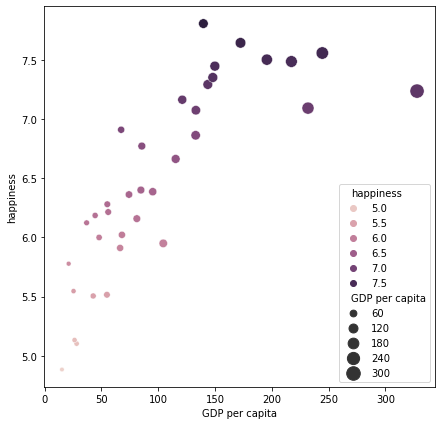

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
sns.scatterplot(x='GDP per capita', y='happiness', data=df,
                hue='happiness',     
                size='GDP per capita',
                sizes=(20, 200), 
                legend='brief')
plt.show()

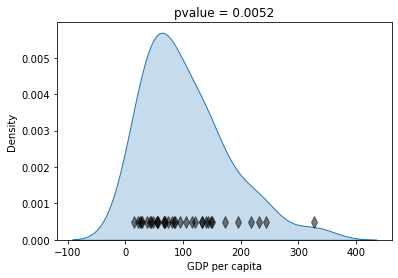

NormaltestResult(statistic=9.604119311771736, pvalue=0.008212814046136909)

In [4]:
cecha = 'GDP per capita'
sns.kdeplot(data=df[cecha], shade=True, color='tab:blue')
plt.plot(df[cecha], np.zeros_like(df[cecha].values)+0.0005, 'd', markersize=8, alpha=0.5, color='black')
from scipy import stats
_, pvalue_norm = stats.shapiro(df[cecha])
plt.title(f'pvalue = {np.round(pvalue_norm,4)}')
plt.show()
stats.normaltest(df[cecha])

HZResults(hz=1.2988117003391013, pval=0.0023841216570631516, normal=False)

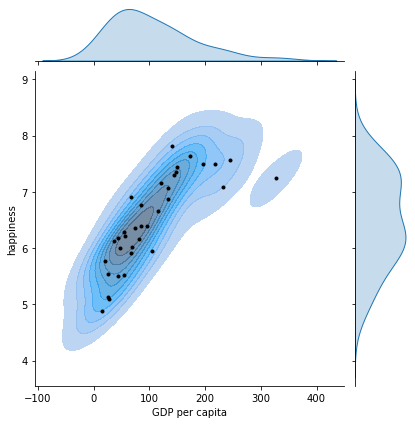

In [5]:
ax = sns.jointplot(x='GDP per capita', y='happiness', data=df, kind='kde', fill=True, alpha=0.7)
ax.ax_joint.plot(df['GDP per capita'], df['happiness'], '.', color='black');
import pingouin
pingouin.multivariate_normality(df)

### III. Modelowanie

Podział danych na część do uczenia i testowania

Wskaźniki jakości modelowania

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75)

Dopasowanie różnych modeli do danych (od prostych do bardziej złożonych)

In [7]:
#================ Model liniowy ================
from sklearn.linear_model import LinearRegression     # klasa modelu

model_lin = LinearRegression()
model_lin.fit(x_train.reshape(-1,1), 
              y_train)
print(f'Model lin params: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
print(f'Model lin MSE: {mean_squared_error(y_test, model_lin.predict(x_test.reshape(-1,1)))}')
print(f'Model lin R2: {model_lin.score(x_train.reshape(-1,1), y_train)}')
print(f'Model lin pvalue: {np.round(stats.linregress(x_train, y_train).pvalue,5)}')

#================ Support Vector Machines (SVR for Regression and SVC for Classification) ================
from sklearn.svm import SVR

model_svr = SVR(kernel='rbf', gamma='scale', C=1)
model_svr.fit(x_train.reshape(-1,1), 
              y_train)
print(f'Model SVR MSE: {mean_squared_error(y_test, model_svr.predict(x_test.reshape(-1,1)))}')

#================ General Linear Model (GLM) ================
from sklearn.preprocessing import PolynomialFeatures

model_GLM = LinearRegression()
gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
model_GLM.fit(gen_features.fit_transform(x_train.reshape(-1,1)), 
              y_train)
print(f'Model GLM params: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
print(f'Model GLM MSE: {mean_squared_error(y_test, model_GLM.predict(gen_features.fit_transform(x_test.reshape(-1,1))))}')

#================ Models predictions for the entire x axis ================
x_plot = np.linspace(start=x.min(), stop=x.max(), num=300)
y_lin_pred_plot = model_lin.predict(x_plot.reshape(-1,1))
y_GLM_pred_plot = model_GLM.predict(gen_features.fit_transform(x_plot.reshape(-1,1)))
y_svr_pred_plot = model_svr.predict(x_plot.reshape(-1,1))

Model lin params: [0.01047], 5.43078
Model lin MSE: 0.41644659361379976
Model lin R2: 0.7178044417302565
Model lin pvalue: 0.0
Model SVR MSE: 0.11985447090782188
Model GLM params: [ 0.      0.0268 -0.0001], 4.69285
Model GLM MSE: 0.14502774457097056


Zaawansowana ocena modelu: __walidacja krzyżowa__

In [8]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=10)
cross_val_score(model_svr, x.reshape(-1,1), y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

array([-0.27647568, -0.12210534, -0.0515069 , -0.08623286, -0.08521372,
       -0.06678923, -0.17309954, -0.03942518, -0.44074799, -0.26641821])

Zapisanie modelu do pliku

In [9]:
import joblib
joblib.dump(model_svr, "svr_GDP.pkl")

f_model_svr = joblib.load("svr_GDP.pkl")

### IV. Przedstawienie wyników

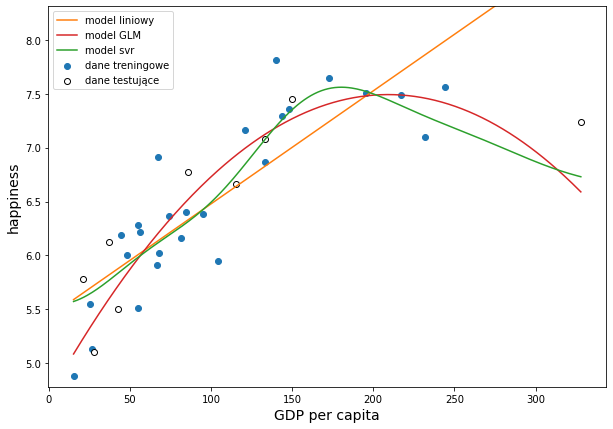

In [10]:
import matplotlib.pyplot as plt
#================ Visualize the dataset and models ======================

plt.figure(figsize=(10,7))
plt.scatter(x_train, y_train, label='dane treningowe')
plt.scatter(x_test, y_test, edgecolor='black', facecolor='white', label='dane testujące')
plt.plot(x_plot, y_lin_pred_plot, label='model liniowy', color='tab:orange')
plt.plot(x_plot, y_GLM_pred_plot, label=f'model GLM', color='tab:red')
plt.plot(x_plot, y_svr_pred_plot, label='model svr', color='tab:green')
plt.xlabel(df.columns[0], fontsize=14)
plt.ylabel(df.columns[1], fontsize=14)
plt.legend()
plt.ylim([y.min()-0.1, y.max()+0.5])
plt.show()

# **Źródła danych**

### __Gotowce__ na potrzeby testowania metod uczenia maszynowego

[Scikit-learn datasets](https://scikit-learn.org/stable/datasets.html)

In [11]:
from sklearn import datasets

#datasets.load_digits()
#datasets.load_boston()
#datasets.load_iris()

[Seaborn `load_dataset()`](https://seaborn.pydata.org/generated/seaborn.load_dataset.html)

In [12]:
from seaborn import load_dataset
df = load_dataset('titanic')

[Kaggle](https://www.kaggle.com/datasets)

### Dane __sztuczne__

In [13]:
x, y, params = datasets.make_regression(n_samples=100,
                                        n_features=4,
                                        n_informative=3,
                                        n_targets=1,
                                        noise=0.0,
                                        coef=True)

x, c = datasets.make_classification(n_samples=100,
                                    n_features=4,
                                    n_informative=3,
                                    n_redundant=1,
                                    n_classes=3,
                                    weights =[0.5, 0.25, 0.25])

x, c = datasets.make_blobs(n_samples=100,
                           n_features=4,
                           centers=3,
                           cluster_std=1,
                           shuffle=True)
# plt.scatter(x[:,1], x[:,2], c=c)

### Zapytania do baz danych SQL

In [14]:
'''
import sqlalchemy as db
engine = db.create_engine('sqlite:///sample.db')
df = pd.read_sql_query('SELECT * FROM data', engine, chunksize=n)
'''

"\nimport sqlalchemy as db\nengine = db.create_engine('sqlite:///sample.db')\ndf = pd.read_sql_query('SELECT * FROM data', engine, chunksize=n)\n"

### Dane __finansowe__ - szeregi czasowe

[pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html)

,Date,High,Low,Open,Close,Volume,Adj Close
64,2020-04-03,1926.329956,1889.150024,1911.150024,1906.589966,3609900,1906.589966
49,2020-03-13,1786.310059,1680.619995,1755.000000,1785.000000,8809700,1785.000000
229,2020-11-27,3216.189941,3190.050049,3211.260010,3195.340088,2392900,3195.340088
367,2021-06-17,3497.199951,3401.000000,3403.179932,3489.239990,5136500,3489.239990
214,2020-11-05,3366.800049,3288.879883,3319.969971,3322.000000,5789300,3322.000000


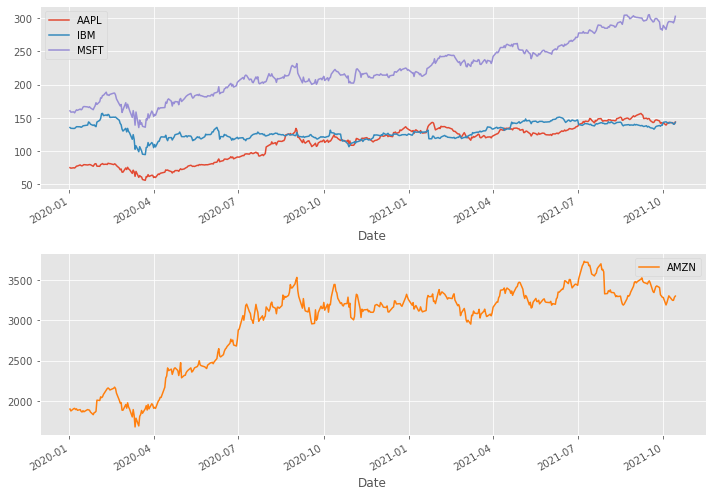

In [15]:
from pandas_datareader import data

start = '2020-1-1'
end = '2021-10-14'
source = 'yahoo'
apple = data.DataReader("AAPL", start=start ,end=end, data_source=source).reset_index()
ibm = data.DataReader("IBM", start=start ,end=end, data_source=source).reset_index()
microsoft = data.DataReader("MSFT", start=start ,end=end, data_source=source).reset_index()
amazon = data.DataReader("AMZN", start=start ,end=end, data_source=source).reset_index()

display(amazon.sample(5))

apple['Company'] = 'AAPL'
ibm['Company'] = 'IBM'
microsoft['Company'] = 'MSFT'
amazon['Company'] = 'AMZN'

features = ['Date', 'Close', 'Company']
stocks = pd.concat([ apple[features], ibm[features], microsoft[features], amazon[features]], axis=0)

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(2, 1, figsize=(10,7))
    for company in stocks['Company'].unique()[:3]:
        stocks[stocks['Company']==company].plot(ax=ax[0], x='Date')
    stocks[stocks['Company']=='AMZN'].plot(ax=ax[1], x='Date', color='tab:orange')    
    ax[0].legend(stocks['Company'].unique()[:3])
    ax[1].legend(stocks['Company'].unique()[-1:])
    plt.tight_layout()
plt.show()

Jeżeli ktoś uzyska (np. zakupi) odpowiedni klucz dostępu, to można tak:

[IEX](https://iexcloud.io/) [Quandl](https://www.quandl.com/) via REST APIs

In [16]:
# import pandas_datareader.data as web
# df = web.DataReader(name='AMZN', data_source='iex', start=start, end=end)
# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-iex

### **Pliki** ze stron

In [17]:
plik = 'owid-covid-data.xlsx'
URL = 'https://covid.ourworldindata.org/data/' + plik
if not os.path.isfile(plik):
    print('Pobieram plik ', URL)
    urllib.request.urlretrieve(URL, plik)
print('Pobrano.')

Pobrano.


In [18]:
dane_full = pd.read_excel(plik)

dane_full['date'] = pd.DatetimeIndex(dane_full['date'])
dane_full.set_index('date', inplace=True)
dane_full.sample(4)

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2021-07-06,BOL,South America,Bolivia,448213.0,1851.0,1512.857,17013.0,28.0,44.429,37878.427,...,NaN,NaN,25.383,1.1,71.51,0.718,NaN,NaN,NaN,NaN
2021-09-11,ARG,South America,Argentina,5223604.0,1795.0,3028.429,113356.0,74.0,130.286,114538.093,...,16.2,27.7,NaN,5.0,76.67,0.845,NaN,NaN,NaN,NaN
2021-08-17,KAZ,Asia,Kazakhstan,774760.0,7597.0,7702.571,11725.0,0.0,133.429,40787.666,...,7.0,43.1,98.999,6.7,73.60,0.825,NaN,NaN,NaN,NaN
2020-11-04,GHA,Africa,Ghana,48643.0,443.0,124.000,320.0,0.0,0.571,1532.926,...,0.3,7.7,41.047,0.9,64.07,0.611,NaN,NaN,NaN,NaN


In [19]:
ciekawe_cechy = ['continent', 'location',
                 'total_cases', 'new_cases', 
                 'total_deaths', 'new_deaths', 
                 'new_tests', 'positive_rate', 'tests_per_case',
                 'reproduction_rate', 'total_vaccinations', 
                 'population', 'median_age', 'aged_65_older', 
                 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'human_development_index']

dane = dane_full[ciekawe_cechy]

print('Liczba państw:', len(dane['location'].unique()), '\n')

Liczba państw: 233 



In [20]:
dane_Pol = dane[dane['location'] == 'Poland']
dane_Ger = dane[dane['location'] == 'Germany']

In [21]:
cecha = 'new_cases'
dane_Pol.insert(1, 'MA_'+cecha, dane_Pol[cecha].rolling(7).mean())
dane_Ger.insert(1, 'MA_'+cecha, dane_Ger[cecha].rolling(7).mean())

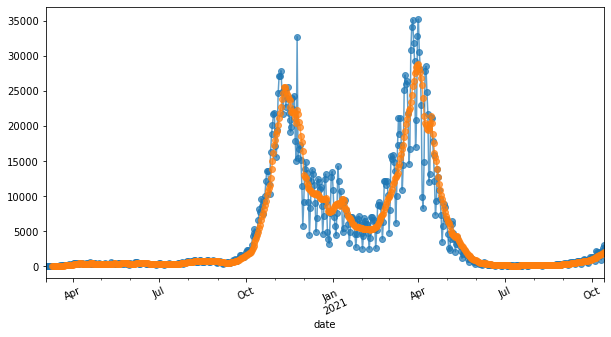

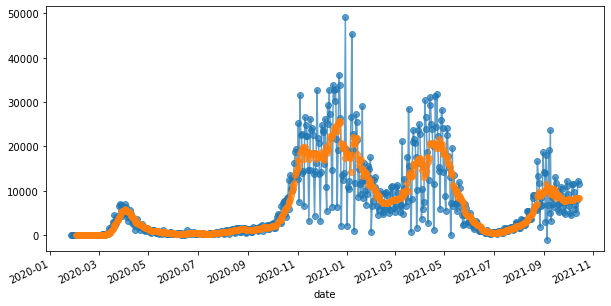

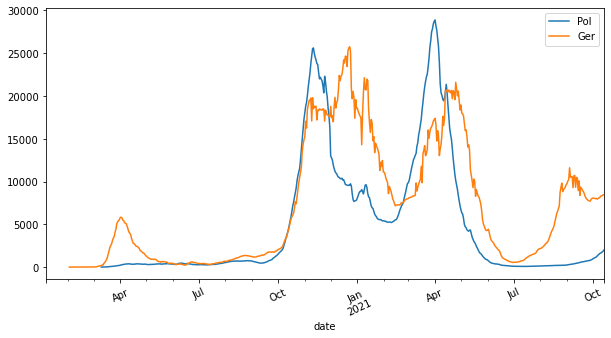

In [22]:
plt.figure(1)
dane_Pol[cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
dane_Pol['MA_'+cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
plt.figure(2)
dane_Ger[cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
dane_Ger['MA_'+cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
plt.figure(3)
dane_Pol['MA_'+cecha].plot(rot=25, figsize=(10,5), label='Pol', legend=True)
dane_Ger['MA_'+cecha].plot(rot=25, figsize=(10,5), label='Ger', legend=True)
plt.show()

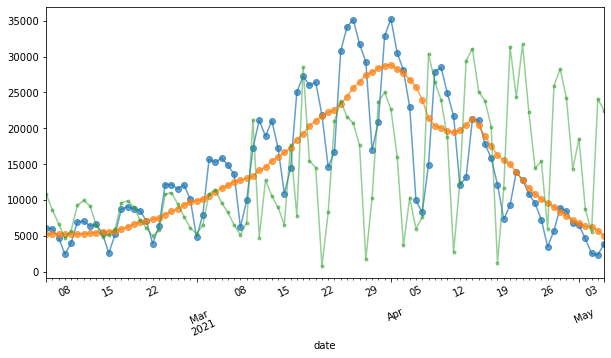

In [23]:
od_daty = '2021-02-05'
do_daty = '2021-05-05'
dane_Pol[od_daty:do_daty][cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
dane_Pol[od_daty:do_daty]['MA_'+cecha].plot(rot=25, figsize=(10,5), marker='o', alpha=0.7)
dane_Ger[od_daty:do_daty][cecha].plot(rot=25, figsize=(10,5), marker='.', alpha=0.5)
plt.show()

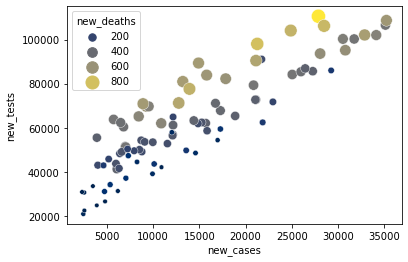

In [24]:
sns.scatterplot(data=dane_Pol[od_daty:do_daty], x="new_cases", y="new_tests", 
                hue='new_deaths', size='new_deaths', sizes=(20, 200),
                palette="cividis");

In [25]:
cecha='MA_new_cases'
dane_scat = pd.DataFrame({'Niemcy '+cecha: dane_Ger[od_daty:do_daty][cecha], 'Polska '+cecha: dane_Pol[od_daty:do_daty][cecha]})

<AxesSubplot:xlabel='Polska MA_new_cases', ylabel='Niemcy MA_new_cases'>

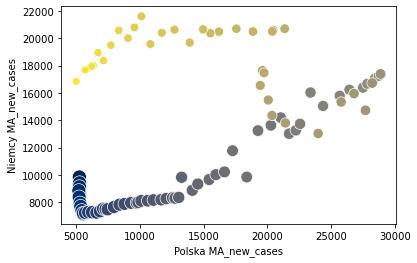

In [26]:
sns.scatterplot(x='Polska '+cecha, y='Niemcy '+cecha, data=dane_scat,
                    hue='date',     # dla łatwiejszego dostrzeżenia regularności pokolorujemy zależnie od wartości Y
                    size='date',        # i dodatkowo rozmiary punktów powiążemy z wartością X
                    sizes=(60, 200), 
                    legend=None, palette="cividis")

### **Google Trends**

In [27]:
from pytrends.request import TrendReq

pytrend = TrendReq()

In [28]:
keyword = 'Geralt'
pytrend.build_payload(kw_list=[keyword])

<AxesSubplot:xlabel='geoName'>

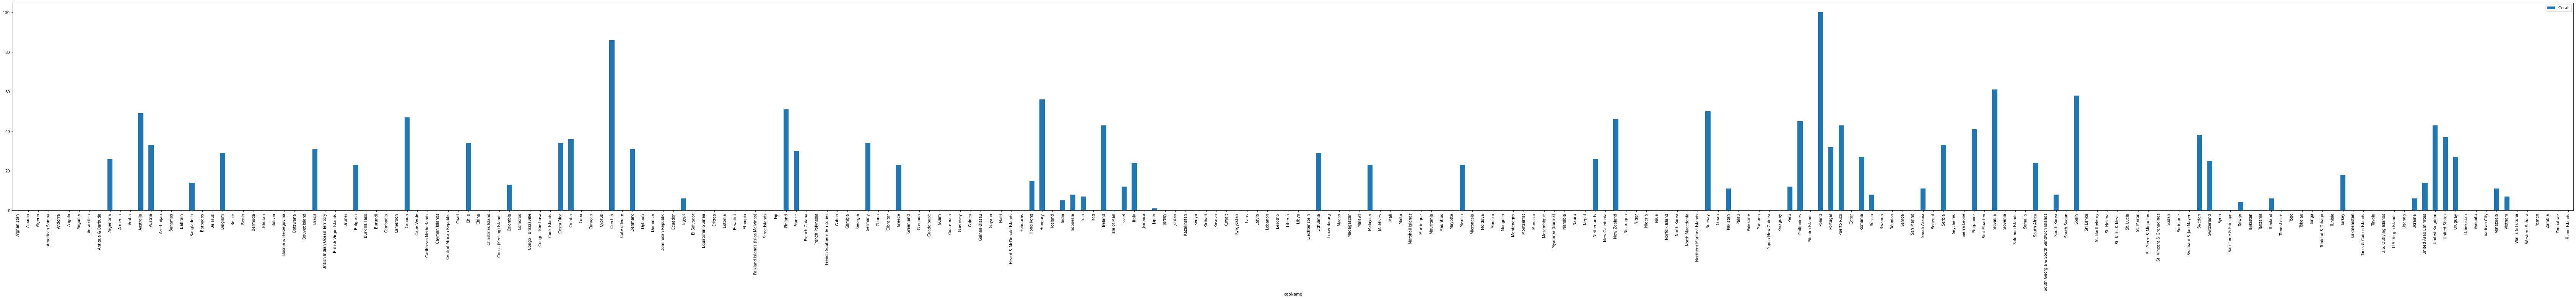

In [29]:
df = pytrend.interest_by_region()
df.reset_index().plot(x='geoName', y=keyword, figsize=(120, 10), kind ='bar')

In [30]:
df = pytrend.trending_searches(pn='poland')
df.head()

,0
0,Adele
1,Paweł Nowisz
2,Punkty szczepień COVID
3,Brittany Murphy
4,Andrzej Grabowski


In [31]:
df = pytrend.today_searches(pn='PL')
df

0                        Adele
1                 Paweł Nowisz
2       Punkty szczepień COVID
3              Brittany Murphy
4            Andrzej Grabowski
5     Dzień Dziecka Utraconego
6              15 października
7          Katarzyna Zdanowicz
8                       Banksy
9                         Rota
10    Podwyżki dla nauczycieli
11           Elizabeth Debicki
Name: query, dtype: object

In [32]:
pytrend.build_payload(kw_list=[keyword])

related_queries = pytrend.related_queries()
related_queries.values()

dict_values([{'top':                    query  value
0         geralt witcher    100
1                witcher     97
2           geralt rivia     93
3              geralt of     83
4        geralt of rivia     62
5     the witcher geralt     56
6            the witcher     53
7       witcher 3 geralt     44
8              witcher 3     43
9        geralt de rivia     29
10       yennefer geralt     22
11              yennefer     21
12           geralt ciri     20
13                  ciri     19
14         the witcher 3     17
15  the witcher 3 geralt     17
16      geralt the rivia     15
17         cavill geralt     12
18   henry cavill geralt     12
19          henry cavill     11
20          ciri witcher     11
21          geralt triss     10
22        geralt netflix     10
23      yennefer witcher     10
24        geralt jaskier      8, 'rising':                            query   value
0                  cavill geralt  348300
1            henry cavill geralt  332900
2            

In [33]:
related_topic = pytrend.related_topics()
related_topic.values()

dict_values([{'rising':      value formattedValue                                            link  \
0   333350       Breakout      /trends/explore?q=/m/070c9h&date=today+5-y   
1   115200       Breakout  /trends/explore?q=/g/11dzzyyv18&date=today+5-y   
2    71650       Breakout     /trends/explore?q=/m/025w7h_&date=today+5-y   
3    65450       Breakout      /trends/explore?q=/m/017d09&date=today+5-y   
4    46850       Breakout      /trends/explore?q=/m/0dpt5q&date=today+5-y   
5    41750       Breakout  /trends/explore?q=/g/11gdt9tqzf&date=today+5-y   
6    40050       Breakout  /trends/explore?q=/g/11j0wm2kw8&date=today+5-y   
7    30100       Breakout       /trends/explore?q=/m/0p8wy&date=today+5-y   
8    29300       Breakout  /trends/explore?q=/g/11gxjt821c&date=today+5-y   
9    23300       Breakout  /trends/explore?q=/g/11gxjt89bw&date=today+5-y   
10   16950       Breakout  /trends/explore?q=/g/11j00ldgjf&date=today+5-y   
11   15350       Breakout     /trends/explore?q=/m/0

### Ektrakcja danych ze stron internetowych (ang. **web scraping**) 

In [34]:
import requests
from bs4 import BeautifulSoup 

URL = "https://pl.wikipedia.org/wiki/Dane_statystyczne_o_miastach_w_Polsce"
resp = requests.get(URL) 
if resp.status_code == 200:
    soup = BeautifulSoup(resp.content,'html.parser')
    tab = soup.find('table',{'class':"wikitable"})
df = pd.read_html(str(tab))[0]
df.head()

,Miasto,Powiat,Województwo,Powierzchnia [ha] (01.01.2020),Liczba ludności (01.01.2020),Gęstość zaludnienia [osoby/km²] (01.01.2020)
0,Aleksandrów Kujawski,aleksandrowski,kujawsko-pomorskie,723,12102,1674
1,Aleksandrów Łódzki,zgierski,łódzkie,1382,21739,1573
2,Alwernia,chrzanowski,małopolskie,888,3344,377
3,Andrychów,wadowicki,małopolskie,1033,20016,1938
4,Annopol,kraśnicki,lubelskie,773,2488,322


In [35]:
tabela = df.drop(["Powiat"], axis=1)
tabela = tabela.rename(columns={"Powierzchnia [ha] (01.01.2020)": "Powierzchnia",
                                "Liczba ludności (01.01.2020)": "Ludność",
                                "Gęstość zaludnienia [osoby/km²] (01.01.2020)": "Gęstość zaludnienia"})
tabela

,Miasto,Województwo,Powierzchnia,Ludność,Gęstość zaludnienia
0,Aleksandrów Kujawski,kujawsko-pomorskie,723,12102,1674
1,Aleksandrów Łódzki,łódzkie,1382,21739,1573
2,Alwernia,małopolskie,888,3344,377
3,Andrychów,małopolskie,1033,20016,1938
4,Annopol,lubelskie,773,2488,322
...,...,...,...,...,...
949,Żukowo,pomorskie,473,6689,1414
950,Żuromin,mazowieckie,1118,8816,789
951,Żychlin,łódzkie,868,8109,934
952,Żyrardów,mazowieckie,1435,39828,2775


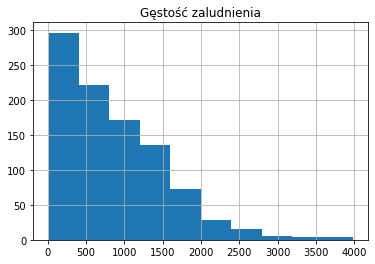

In [36]:
tabela[['Gęstość zaludnienia']].hist();

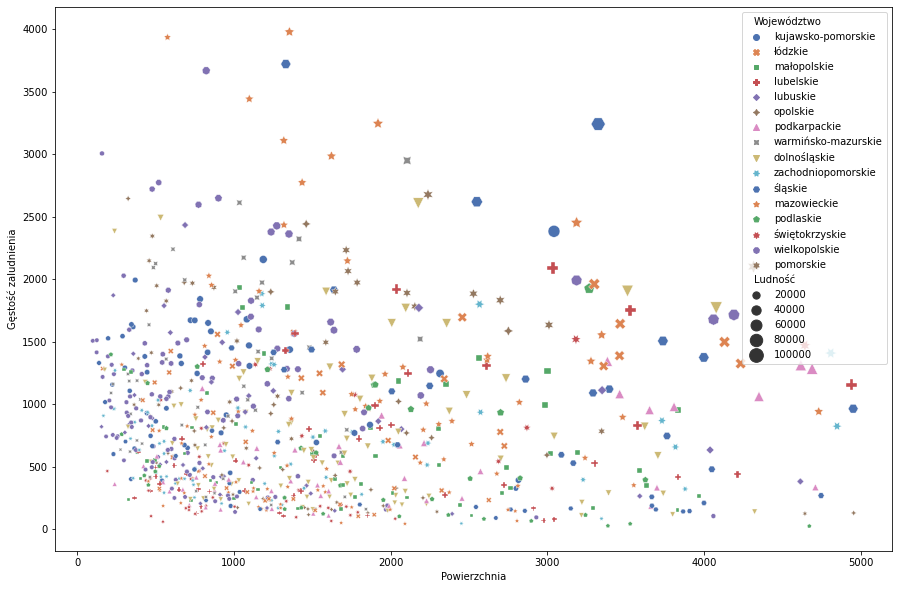

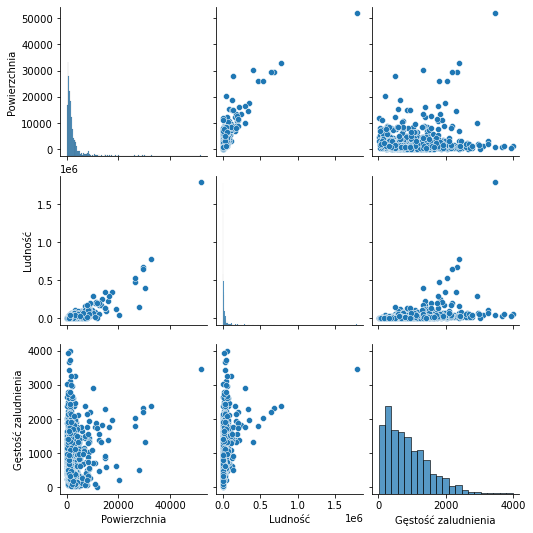

In [37]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=tabela[tabela['Powierzchnia']<5000], x="Powierzchnia", y="Gęstość zaludnienia", 
                hue='Województwo', style='Województwo', size='Ludność', sizes=(20, 200),
                palette="deep");
sns.pairplot(tabela)

In [38]:
tabela.sort_values(by='Ludność', ascending=False).head(20)

,Miasto,Województwo,Powierzchnia,Ludność,Gęstość zaludnienia
849,Warszawa,mazowieckie,51724,1790658,3462
327,Kraków,małopolskie,32685,779115,2384
411,Łódź,łódzkie,29325,679941,2319
893,Wrocław,dolnośląskie,29282,642869,2195
601,Poznań,wielkopolskie,26191,534813,2042
165,Gdańsk,pomorskie,26196,470907,1798
770,Szczecin,zachodniopomorskie,30060,401907,1337
72,Bydgoszcz,kujawsko-pomorskie,17598,348190,1979
378,Lublin,lubelskie,14747,339784,2304
25,Białystok,podlaskie,10213,297554,2913


# __Przykład II postępowania z danymi i modelami__

In [39]:
plik = 'pomiary2017.xlsx'
url = "https://byes.pl/wp-content/uploads/datasets/" + plik
if not os.path.isfile(plik):
    print('Pobieram plik ', url)
    urllib.request.urlretrieve(url, plik)

pomiary = pd.read_excel(plik)
display(pomiary.head(6))
display(pomiary.tail(2))

,nr osoby,c. górne,c. dolne,puls,waga,wzrost,płeć
0,1,162,96,136,78,184.0,M
1,2,141,84,81,187,78.0,M
2,3,137,79,87,78,178.0,M
3,4,139,79,97,65,NaN,M
4,5,126,76,73,60,175.0,M
5,6,138,74,78,89,197.0,M


,nr osoby,c. górne,c. dolne,puls,waga,wzrost,płeć
41,42,116,74,100,59,180.0,M
42,43,113,74,78,60,176.0,M


__Czyszczenie danych__

In [40]:
pom = pomiary.loc[1,'wzrost']
pomiary.loc[1,'wzrost'] = pomiary.loc[1,'waga']
pomiary.loc[1,'waga'] = pom

pomiary['wzrost'].fillna(pomiary['wzrost'].mean(axis=0), inplace=True)
pomiary['wzrost'] = pomiary['wzrost'].astype(int)

display(pomiary.head(6))

,nr osoby,c. górne,c. dolne,puls,waga,wzrost,płeć
0,1,162,96,136,78.0,184,M
1,2,141,84,81,78.0,187,M
2,3,137,79,87,78.0,178,M
3,4,139,79,97,65.0,177,M
4,5,126,76,73,60.0,175,M
5,6,138,74,78,89.0,197,M


(43,)


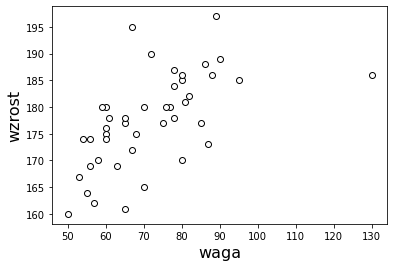

In [41]:
atrybut_x = 'waga'
atrybut_y = 'wzrost'
X = pomiary[atrybut_x].values
Y = pomiary[atrybut_y].values
print(X.shape)
plt.scatter(X, Y, marker='o', facecolors='white', edgecolors='black')
plt.xlabel(atrybut_x, fontsize=16)
plt.ylabel(atrybut_y, fontsize=16)
plt.show()

__Usuwanie odstających danych i niepotrzebnych atrybutów__

In [42]:
pomiary = pomiary[pomiary[atrybut_x] < 120]
pomiary.drop('nr osoby', axis=1, inplace=True)

X = pomiary[atrybut_x].values
Y = pomiary[atrybut_y].values

**Wstępna analiza - poszukiwanie prostych regularności**

In [43]:
pomiary.describe()

,c. górne,c. dolne,puls,waga,wzrost
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,130.809524,77.285714,85.428571,70.380952,177.380952
std,13.911284,7.645454,16.820636,12.064769,8.787331
min,103.000000,50.000000,63.000000,50.000000,160.000000
25%,120.000000,74.000000,73.750000,60.000000,172.250000
50%,130.000000,78.000000,80.000000,69.000000,177.500000
75%,140.000000,80.750000,89.500000,80.000000,183.500000
max,162.000000,96.000000,136.000000,95.000000,197.000000


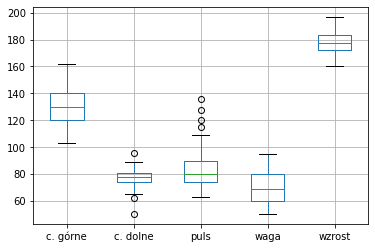

In [44]:
pomiary.boxplot(return_type='axes');

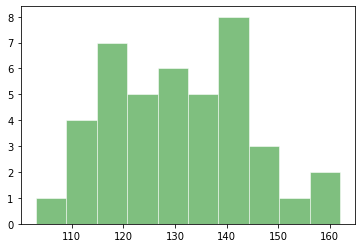

In [45]:
plt.hist(pomiary['c. górne'], edgecolor='white', facecolor='green', alpha=0.5);

In [46]:
pd.crosstab(pomiary['wzrost'] > 170, pomiary['waga'] > 60)

waga,False,True
wzrost,,
False,6,4
True,7,25


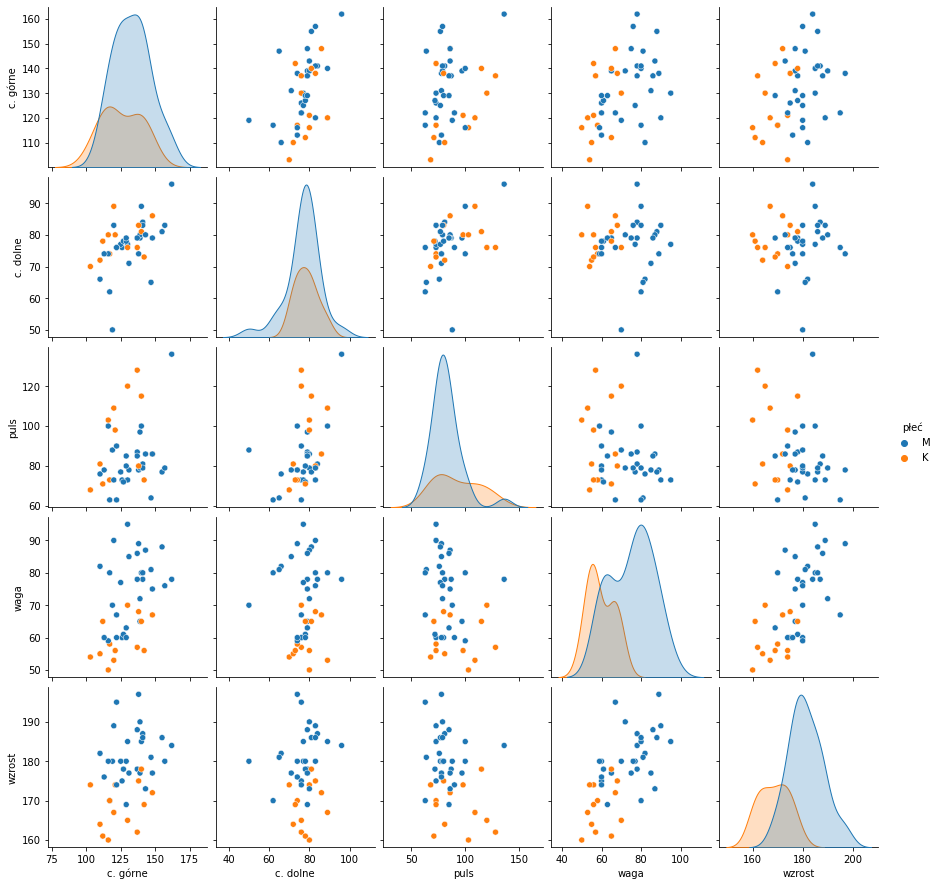

In [47]:
import seaborn as sns
sns.pairplot(pomiary, hue='płeć', height=2.5)
plt.show()

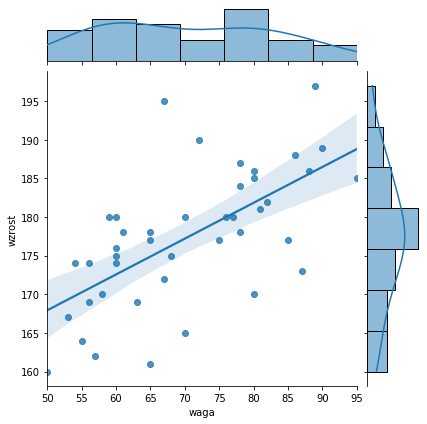

In [48]:
sns.jointplot(x='waga', y='wzrost', data=pomiary, kind='reg')
plt.show()

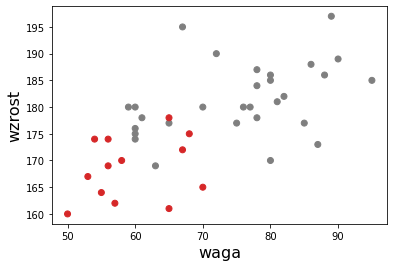

In [49]:
plecMK = pomiary['płeć'].to_list()
plecKolor = ['tab:grey' if p=='M' else 'tab:red' for p in plecMK]
plec01 = np.array([0 if p=='M' else 1 for p in plecMK])

plt.scatter(X, Y, marker='o', facecolors=plecKolor)
plt.xlabel(atrybut_x, fontsize=16)
plt.ylabel(atrybut_y, fontsize=16)
plt.show()

#### **Klasyfikacja**

In [50]:
XX = np.array(pomiary[[atrybut_x, atrybut_y]])
XX = XX.reshape(-1,2)

XX_tren, XX_test, Y_tren, Y_test = train_test_split(XX, plecMK)

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(XX_tren, Y_tren)

KNeighborsClassifier(n_neighbors=1)

In [52]:
XX_nowy = np.array([[60, 150]])
pred = knn.predict(XX_nowy)
print(pred)

['K']


In [53]:
Y_pred = knn.predict(XX_test)
print(Y_pred)

['M' 'M' 'M' 'M' 'M' 'K' 'M' 'K' 'K' 'M' 'K']


In [54]:
print(np.mean(Y_pred == Y_test))

0.9090909090909091


In [55]:
print(knn.score(XX_test, Y_test))

0.9090909090909091


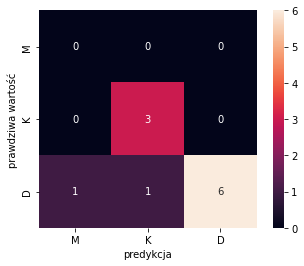

In [56]:
from sklearn.metrics import confusion_matrix

Y_pred[3] = 'D'
mat = confusion_matrix(Y_test, Y_pred)

sns.heatmap(mat, square=True, annot=True, cbar=True,
           xticklabels=['M','K','D'],
           yticklabels=['M','K','D'])
plt.xlabel('predykcja')
plt.ylabel('prawdziwa wartość')

plt.show()

Walidacja krzyżowa

In [57]:
from sklearn.model_selection import cross_val_score

dokladnosc = cross_val_score(knn, XX, plecMK, cv=5)
print(dokladnosc)
print(dokladnosc.mean())

[0.88888889 0.77777778 1.         1.         0.875     ]
0.9083333333333332


In [58]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
dokladnosc = cross_val_score(knn, XX, plecMK, cv=kfold)
print(dokladnosc)
print(dokladnosc.mean())

[0.77777778 1.         0.875      1.         0.875     ]
0.9055555555555556


In [59]:
kfold = KFold(n_splits=5, shuffle=True)
dokladnosc = cross_val_score(knn, XX, plecMK, cv=kfold)
print(dokladnosc)
print(dokladnosc.mean())

[1.    1.    0.75  0.875 1.   ]
0.925


In [60]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
dokladnosc = cross_val_score(knn, XX, plecMK, cv=loo)
print(dokladnosc)
print(dokladnosc.mean())

[1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
0.9047619047619048


#### **Grupowanie**

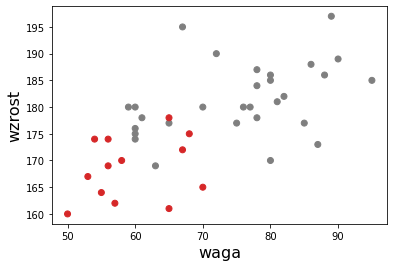

In [61]:
plt.scatter(X, Y, marker='o', facecolors=plecKolor)
plt.xlabel(atrybut_x, fontsize=16)
plt.ylabel(atrybut_y, fontsize=16)
plt.show()

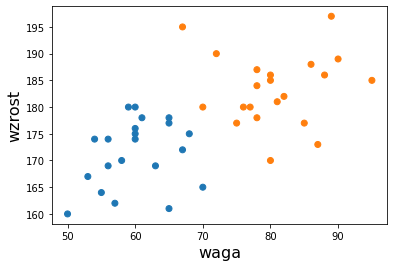

In [62]:
import sklearn.cluster
km = sklearn.cluster.KMeans(n_clusters=2)
km.fit(XX)

g_pred = km.fit_predict(XX)
grupaKolor = ['tab:blue' if g==0 else 'tab:orange' for g in g_pred]

plt.scatter(X, Y, marker='o', facecolors=grupaKolor)
plt.xlabel(atrybut_x, fontsize=16)
plt.ylabel(atrybut_y, fontsize=16)
plt.show()

Transformacja cech

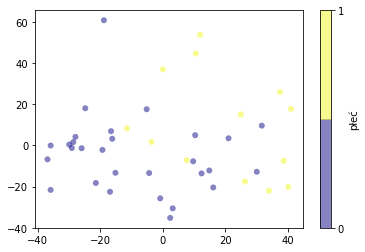

In [63]:
from sklearn.manifold import Isomap

XXX = np.array(pomiary[['c. górne', 'c. dolne', 'puls', 'waga', 'wzrost']])

iso = Isomap(n_components=2)
iso.fit(XXX)
XXX2 = iso.transform(XXX)

plt.scatter(XXX2[:,0], XXX2[:,1], c=plec01,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('plasma', 2))
plt.colorbar(label='płeć', ticks=range(10))
#plt.clim([0, 1])
plt.show()

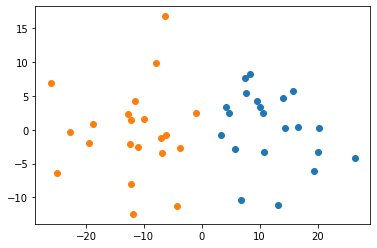

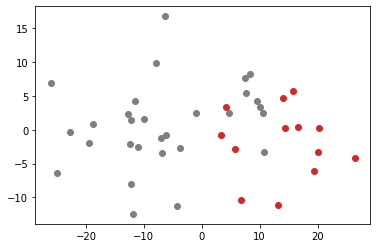

In [64]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(XX)

XX2 = pca.transform(XX)
g0 = (g_pred==0)
g1 = ~g0
plt.figure(1)
plt.scatter(XX2[g0,0], XX2[g0,1], marker='o', facecolor='tab:blue')
plt.scatter(XX2[g1,0], XX2[g1,1], marker='o', facecolor='tab:orange')
plt.show()
plt.figure(2)
g0 = (plec01==0)
g1 = (plec01==1)
plt.scatter(XX2[g0,0], XX2[g0,1], marker='o', facecolor='tab:grey')
plt.scatter(XX2[g1,0], XX2[g1,1], marker='o', facecolor='tab:red')
plt.show()

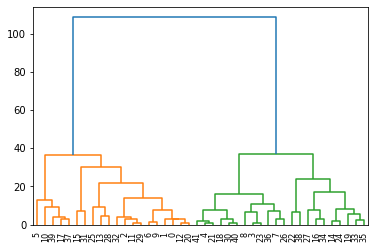

In [65]:
import scipy.cluster.hierarchy
hw = scipy.cluster.hierarchy.ward(XX)
den = scipy.cluster.hierarchy.dendrogram(hw, no_labels=False)
plt.show()

In [66]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

drzewo = DecisionTreeClassifier(max_depth=3)
modrzew = drzewo.fit(XX, plec01)
print(modrzew.predict([[60,145]]))
print(modrzew.predict([[80,195]]))

[1]
[0]


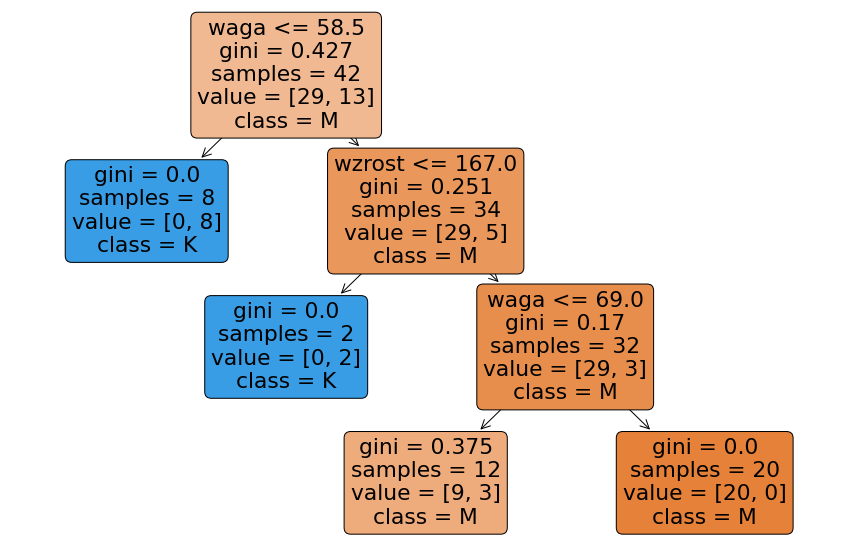

In [67]:
fig = plt.figure(figsize=(15,10))
plot_tree(modrzew, 
          feature_names=['waga', 'wzrost'], 
          class_names=['M','K'],
          filled=True, rounded = True
         )
plt.show()

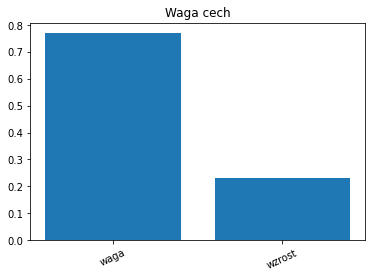

In [68]:
importances = modrzew.feature_importances_

indices = np.argsort(importances)[::-1]
names = ['waga', 'wzrost']
plt.figure()
plt.title('Waga cech')
plt.bar(range(XX.shape[1]), importances[indices])
plt.xticks(range(XX.shape[1]), names, rotation=25)
plt.show()

In [69]:
from sklearn.naive_bayes import GaussianNB

klasyfikator = GaussianNB().fit(XX, plec01)

print(klasyfikator.predict([[60,145]]))
print(klasyfikator.predict([[80,195]]))

[1]
[0]


### **Szyte na miarę**

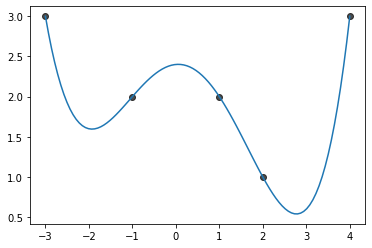

In [70]:
from scipy import linalg

x = np.array([4, 2, 1, -3, -1])
y = np.array([3, 1, 2, 3, 2])


def makeX(x):
    return np.vstack([x**0, x**1, x**2, x**3, x**4]).T


X = makeX(x)
pars, _, _, _ = linalg.lstsq(X, y)

xx = np.linspace(x.min(), x.max(), num=100)
XX = makeX(xx)

yy_pred = np.dot(XX, pars)

plt.plot(xx, yy_pred)
plt.scatter(x, y, marker='o', color='black', alpha=0.7)
plt.show()

Parameters estimated: [-2.15662695e+00  2.34066901e+01  4.22965236e-03]
MSE: 86.45148068114959


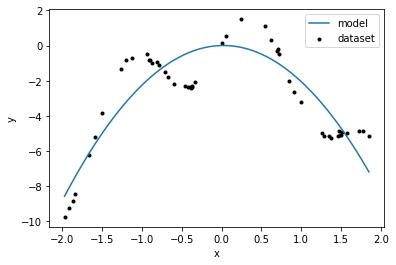

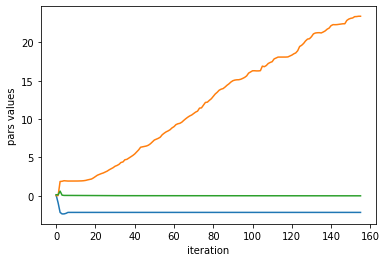

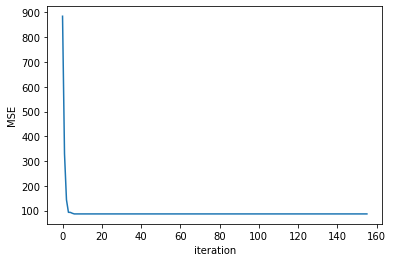

In [71]:
from scipy import optimize

# artificial dataset
N = 50
x = np.random.uniform(-2, 2, size=N)
disturbances = np.random.normal(loc=0, scale=0.1, size=N)
y = -2*x**2 + 2*np.sin(4*x) + disturbances
dataset = {'x': x, 
           'y': y}


def model(pars, x):
    return pars[0]*x**2 + pars[1]*np.sin(pars[2]*x)


# mean squared error - performance index
def MSE(pars, model, dataset):
    y_pred = model(pars, dataset['x'])
    return ((dataset['y']-y_pred)**2).sum()

initial_sol = np.random.normal(0,0.1,size=3)
pars_est, x_history = optimize.fmin_bfgs(MSE, initial_sol, args=(model, dataset,), disp=False, retall=True)
print(f'Parameters estimated: {pars_est}')
print(f'MSE: {MSE(pars_est, model, dataset)}')

xx = np.linspace(start=x.min(), stop=x.max(), num=300)
yy = model(pars_est, xx)
plt.figure(1)
plt.plot(xx,yy, label='model')
plt.scatter(x, y, marker='.', color='black', label='dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.figure(2)
plt.plot(x_history)
plt.xlabel('iteration')
plt.ylabel('pars values')
plt.figure(3)
plt.plot([MSE(pars, model, dataset) for pars in x_history])
plt.xlabel('iteration')
plt.ylabel('MSE')
plt.show()